In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pennylane

In [3]:
#improt pennylane dependnecies
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer


# load the csv files
import pandas as pd

# plot the historical acc and cost
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import clear_output
clear_output(wait=False)

import os



In [4]:
data_train = pd.read_csv("dataset/fair_train.csv")
X_train,y_train = data_train[data_train.columns[:16]].values, data_train[data_train.columns[16]].values

data_test = pd.read_csv("dataset/classic_test.csv")
X_test,y_test = data_test[data_test.columns[:16]].values, data_test[data_test.columns[16]].values

(X_train.shape, y_train.shape),(X_test.shape, y_test.shape)

(((2000, 16), (2000,)), ((6159, 16), (6159,)))

**Best Parameters**

In [5]:
dev = qml.device("default.qubit", wires=4)

In [6]:
def layer_1(W):

    qml.RY(W[0], wires=0)
    qml.RY(W[1], wires=1)
    qml.RY(W[2], wires=2)
    qml.RY(W[3], wires=3)


    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    qml.RZ(W[4], wires=0)
    qml.RZ(W[5], wires=1)
    qml.RZ(W[6], wires=2)
    qml.RZ(W[7], wires=3)


    qml.CNOT(wires=[1,0])
    qml.RY(W[8], wires=1)
    qml.CNOT(wires=[2,0])
    qml.RY(W[9], wires=2)
    qml.CNOT(wires=[3,0])
    qml.RY(W[10], wires=3)

    qml.CNOT(wires=[2,1])
    qml.RY(W[11], wires=2)
    qml.CNOT(wires=[3,1])
    qml.RY(W[12], wires=3)

#     qml.Hadamard(wires=0)
#     qml.Hadamard(wires=1)
#     qml.Hadamard(wires=2)
#     qml.Hadamard(wires=3)

    #qml.CNOT(wires=[1,0])
    #qml.CNOT(wires=[2,0])
    #qml.CNOT(wires=[3,0])

In [7]:
def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

n_wires = 4
n_block_wires = 2
n_params_block = 2
n_blocks = qml.MPS.get_n_blocks(range(n_wires),n_block_wires)
n_blocks

3

In [8]:
@qml.qnode(dev)
def circuit(weights, x):

    #statepreparation(x)
    qml.AmplitudeEmbedding(x, wires=[0,1,2,3],normalize=True,pad_with=True)
    #for i in range(4):
        #qml.Hadamard(wires=i)
        #qml.RY(x[i], wires=i)
        #qml.Hadamard(wires=i)
        #qml.RX(x[i+4], wires=i)
        #qml.RX(x[i+8], wires=i)
        
    #qml.CNOT(wires=[0,1])
    #qml.CNOT(wires=[1,2])
    #qml.CNOT(wires=[2,3])
    #qml.CNOT(wires=[3,0])
    #qml.CNOT(wires=[4,0])
    #qml.CNOT(wires=[0,1])
    #qml.CNOT(wires=[1,2])
    #qml.CNOT(wires=[2,3])
    #qml.CNOT(wires=[3,0])
    for w in weights:
        #layer_1(w[:13])
        #layer_2(w[12:21])
        #layer_2(w[16:24])
        #layer_3(w[21:])
        qml.MPS(range(n_wires),n_block_wires,block, n_params_block, w)
        #print(w)
    #print(x)
    
    return qml.expval(qml.PauliZ(3))

In [9]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    #print(1)
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)



In [10]:
np.random.seed(0)
num_layers = 4
weights_init = 2*np.pi * np.random.randn(num_layers,3, 2, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[ 11.08386778   2.51426189]
  [  6.14959212  14.07994722]
  [ 11.73421292  -6.14041802]]

 [[  5.96958159  -0.95100539]
  [ -0.64854317   2.57986647]
  [  0.90505245   9.13746993]]

 [[  4.78174105   0.76450668]
  [  2.78887494   2.09653763]
  [  9.38757568  -1.28904739]]

 [[  1.96706238  -5.3664418 ]
  [-16.0409081    4.10680676]
  [  5.43141282  -4.66316035]]] 0.0


In [11]:
 print(qml.draw(circuit,expansion_strategy='device',wire_order=[0,1,2,3,4,5,6,7])(weights_init,np.asarray(X_train[0])))

0: ─╭QubitStateVector(M0)─╭●──RY(11.08)───────────────╭●──RY(5.97)────────────────╭●──RY(4.78)───
1: ─├QubitStateVector(M0)─╰X──RY(2.51)──╭●──RY(6.15)──╰X──RY(-0.95)─╭●──RY(-0.65)─╰X──RY(0.76)─╭●
2: ─├QubitStateVector(M0)───────────────╰X──RY(14.08)─╭●──RY(11.73)─╰X──RY(2.58)──╭●──RY(0.91)─╰X
3: ─╰QubitStateVector(M0)─────────────────────────────╰X──RY(-6.14)───────────────╰X──RY(9.14)───

────────────╭●──RY(1.97)───────────────────────────────┤     
───RY(2.79)─╰X──RY(-5.37)─╭●──RY(-16.04)───────────────┤     
───RY(2.10)─╭●──RY(9.39)──╰X──RY(4.11)───╭●──RY(5.43)──┤     
────────────╰X──RY(-1.29)────────────────╰X──RY(-4.66)─┤  <Z>


In [12]:
for i in weights_init:
    print(i[0])

[11.08386778  2.51426189]
[ 5.96958159 -0.95100539]
[4.78174105 0.76450668]
[ 1.96706238 -5.3664418 ]


In [13]:
y_train = np.where(y_train < 1, -1, y_train)
y_test = np.where(y_test < 1, -1, y_test)

In [14]:
from sklearn.utils import shuffle
X,y = shuffle(X_train, y_train, random_state=0)


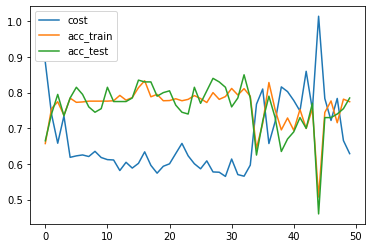

Iter:    50 | Cost: 0.6289603 | Acc train: 0.7744444 | Acc validation: 0.7850000 
[[[ 11.44287858  -0.27646298]
  [  4.97479646  15.01873984]
  [ 11.87265379  -5.4242082 ]]

 [[  4.06308193  -0.11403013]
  [  0.17551624   1.26552672]
  [  1.54258177  10.01166321]]

 [[  5.46269602  -0.53259847]
  [  1.26470646  -3.47505478]
  [  7.57412629  -2.33864524]]

 [[  1.96706238  -7.94980902]
  [-16.0409081    1.67038826]
  [  5.43141282  -6.14178702]]]


In [15]:
from sklearn.model_selection import train_test_split

opt = NesterovMomentumOptimizer(0.4)
batch_size = 32

num_data = len(y_train)
num_train = 0.9
# train the variational classifier
weights = weights_init
bias = bias_init
print()

cost_g = []
acc_train = []
acc_test = []
plt.show()
for it in range(50):
    X_train_70, X_test_30, y_train_70, y_test_30 =train_test_split(np.asarray(X), np.asarray(y), train_size=num_train, test_size=1.0-num_train, shuffle=True)
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train_70), (batch_size,))
    feats_train_batch = X_train_70[batch_index]
    Y_train_batch = y_train_70[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train_70]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_test_30]
    # Compute accuracy on train and validation set
    acc_tra = accuracy(y_train_70, predictions_train)
    acc_val = accuracy(y_test_30, predictions_val)
    cost_train = cost(weights, bias,X_train, y_train)
    cost_g.append(cost_train)
    
    acc_train.append(acc_tra)
    acc_test.append(acc_val)
    
    clear_output(wait=True)
    plt.plot(cost_g,label='cost')
    plt.plot(acc_train,label='acc_train')
    plt.plot(acc_test,label='acc_test')
    plt.legend(['cost','acc_train','acc_test'])
    plt.show()
     
    
    print(
         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
         "".format(it + 1, cost_train, acc_tra, acc_val)
     )
    print(weights)

In [16]:
x_test = []
for x in X_test.tolist():
    if sum(x) == 0:
        x[0]=1
    x_test.append( x/ np.linalg.norm(x))
x_test[0]

array([0.4423974 , 0.5898632 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1474658 , 0.2949316 , 0.4423974 ,
       0.3686645 , 0.        , 0.07225824, 0.07299557, 0.        ,
       0.0737329 ])

In [19]:
y_pred = [np.sign(variational_classifier(weights, bias, f)) for f in x_test]


In [20]:
y_test_pred = []
for i in y_pred:
    if i < 0:
        y_test_pred.append(-1)
    else:
        y_test_pred.append(1)

Accuracy: 0.712616
Precision: 0.379918
Recall: 0.898140
F1 score: 0.533965
Cohens kappa: 0.372228
ROC AUC: 0.784557
[[3375 1655]
 [ 115 1014]]


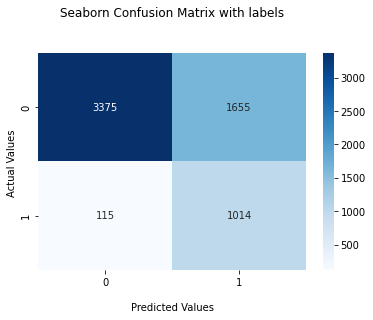

In [21]:

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, y_test_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
test_matrix = confusion_matrix(y_test, y_test_pred)
print(test_matrix)
ax = sns.heatmap(test_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [22]:
y_pred_1 = [int(i) for i in y_pred ]
y_pred_1 = ["{}\n".format(i) for i in y_pred_1]
with open(r'mps_4_layers.csv', 'w') as fp:
    fp.writelines(y_pred_1)